# Multiclass Semantic Segmentation using CamVid dataset

## Introduction
- Semantic Segmentation of an image is to assign each pixel in the input image a semantic class in order to get a pixel-wise dense classification.
- A general semantic segmentation architecture can be broadly thought of as an encoder network followed by a decoder network. - - The encoder is usually is a pre-trained classification network like VGG/ResNet followed by a decoder network. The decoder network/mechanism is mostly where these architectures differ. 
- The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. (mechanisms like skip connections, pyramid pooling etc are used for this)



## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

/home/mirap/anaconda3/envs/alpha/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mirap/anaconda3/envs/alpha/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mirap/anaconda3/envs/alpha/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mirap/anaconda3/envs/alpha/lib/python3.5/site-

# Environment checks

In [2]:
tf.enable_eager_execution()
print(tf.__version__)



1.14.0


In [3]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
print(tf.executing_eagerly())

True


In [5]:
#!wget http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/CamSeq01.zip

In [6]:
cwd = os.getcwd()
cwd

'/home/mirap/tensorflowGUI/alpha/Multiclass-Semantic-Segmentation-CamVid'

In [7]:
#!mkdir data
#!mkdir data/CamSeq01

In [8]:
#!unzip CamSeq01.zip -d data/CamSeq01

## Data preparation - Importing, Cleaning and Creating structured directory 

### Function to import and process frames and masks as tensors

In [9]:
def _read_to_tensor(fname, output_height=1120, output_width=1504, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

### Image directory and size parameters

In [10]:
import shutil


## Try to remove tree; if failed show an error using try...except on screen
#shutil.rmtree("data/CamSeq01/train_frames")
#shutil.rmtree("data/CamSeq01/train_masks")
#shutil.rmtree("data/CamSeq01/val_frames")
#shutil.rmtree("data/CamSeq01/val_masks")

In [11]:
img_dir = 'data/'

# Required image dimensions
output_height = 1120
output_width = 1504

### Reading frames and masks
- Mask file names end in "\_L.png"


In [12]:
def read_images(img_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - file directory
        Outputs 
            frame_tensors, masks_tensors, frame files list, mask files list
    '''
    
    # Get the file names list from provided directory
    file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    file_list.sort()
    
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file for file in file_list if ('png' not in file) and ('txt' not in file)]
    masks_list = [file for file in file_list if ('png' in file) and ('txt' not in file)]
    
    print('{} frame files found in the provided directory.'.format(len(frames_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    frames_paths = [os.path.join(img_dir, fname) for fname in frames_list]
    masks_paths = [os.path.join(img_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    
    return frame_tensors, masks_tensors, frames_list, masks_list

frame_tensors, masks_tensors, frames_list, masks_list = read_images(img_dir)

1522 frame files found in the provided directory.
1522 mask files found in the provided directory.
Completed importing 1522 frame images from the provided directory.
Completed importing 1522 mask images from the provided directory.


In [13]:
#masks_list.sort()
#print(len(masks_list))
# masks_list

In [14]:
#frames_list.sort()
#print(len(frames_list))
# frames_list

### Displaying Images in the train dataset

In [15]:
# Make an iterator to extract images from the tensor dataset

frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)



In [16]:
'''
n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding frames and masks
    fig = plt.figure(figsize=(20,7))
    fig.add_subplot(1,2,1)
    plt.grid(b=None)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.grid(b=None)
    plt.imshow(mask)
    plt.show()
'''

'\nn_images_to_show = 5\n\nfor i in range(n_images_to_show):\n    \n    # Get the next image from iterator\n    frame = frame_batches.next().numpy().astype(np.uint8)\n    mask = mask_batches.next().numpy().astype(np.uint8)\n    \n    #Plot the corresponding frames and masks\n    fig = plt.figure(figsize=(20,7))\n    fig.add_subplot(1,2,1)\n    plt.grid(b=None)\n    plt.imshow(frame)\n    fig.add_subplot(1,2,2)\n    plt.grid(b=None)\n    plt.imshow(mask)\n    plt.show()\n'

### Creating folder structure common for Computer Vision problems

In [17]:
DATA_PATH = 'data/CamSeq01/'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

[Errno 17] File exists: 'data/CamSeq01/train_frames/train'
[Errno 17] File exists: 'data/CamSeq01/train_masks/train'
[Errno 17] File exists: 'data/CamSeq01/val_frames/val'
[Errno 17] File exists: 'data/CamSeq01/val_masks/val'


### Saving frames and masks to correct directories

In [18]:
def generate_image_folder_structure(frames, masks, frames_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            frames - frame tensor dataset
            masks - mask tensor dataset
            frames_list - frame file paths
            masks_list - mask file paths
    '''
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the frames and masks in appropriate folders
    dir_name='train'
    for file in zip(frames_list[:-round(0.2*len(frames_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    #Iterate over the val images while saving the frames and masks in appropriate folders
    dir_name='val'
    for file in zip(frames_list[-round(0.2*len(frames_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} frames to directory {}".format(len(frames_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
## If you already devided it manually, you do not need to run this.   
#generate_image_folder_structure(frame_tensors, masks_tensors, frames_list, masks_list)

#generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

## Extract Target Class definitions

### Function to parse the file "label_colors.txt" which contains the class definitions

In [19]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

### Parse and extract label names and codes

In [20]:
label_codes = [(176,112,32),(176,240,32),(48,112,32),(112,112,32),(48,240,32),(176,240,160),(176,112,160),(48,112,160),(48,240,160),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),(5,5,4),]
label_names = ['Cortical subplate','Hypothalamus','Cerebral nuclei','auditory area','Hippocampal formation','Thalamus','Retrosplenial area','Olfactory area','Somatosensory area','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump']
label_codes[:5], label_names[:5]

([(176, 112, 32),
  (176, 240, 32),
  (48, 112, 32),
  (112, 112, 32),
  (48, 240, 32)],
 ['Cortical subplate',
  'Hypothalamus',
  'Cerebral nuclei',
  'auditory area',
  'Hippocampal formation'])

In [21]:
label_codes, label_names

([(176, 112, 32),
  (176, 240, 32),
  (48, 112, 32),
  (112, 112, 32),
  (48, 240, 32),
  (176, 240, 160),
  (176, 112, 160),
  (48, 112, 160),
  (48, 240, 160),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4),
  (5, 5, 4)],
 ['Cortical subplate',
  'Hypothalamus',
  'Cerebral nuclei',
  'auditory area',
  'Hippocampal formation',
  'Thalamus',
  'Retrosplenial area',
  'Olfactory area',
  'Somatosensory area',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump'])

### Create useful label and code conversion dictionaries
_These will be used for:_
- One hot encoding the mask labels for model training
- Decoding the predicted labels for interpretation and visualization

In [22]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [23]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [24]:
id2code

{0: (176, 112, 32),
 1: (176, 240, 32),
 2: (48, 112, 32),
 3: (112, 112, 32),
 4: (48, 240, 32),
 5: (176, 240, 160),
 6: (176, 112, 160),
 7: (48, 112, 160),
 8: (48, 240, 160),
 9: (5, 5, 4),
 10: (5, 5, 4),
 11: (5, 5, 4),
 12: (5, 5, 4),
 13: (5, 5, 4),
 14: (5, 5, 4),
 15: (5, 5, 4),
 16: (5, 5, 4),
 17: (5, 5, 4),
 18: (5, 5, 4),
 19: (5, 5, 4),
 20: (5, 5, 4),
 21: (5, 5, 4),
 22: (5, 5, 4),
 23: (5, 5, 4),
 24: (5, 5, 4),
 25: (5, 5, 4),
 26: (5, 5, 4),
 27: (5, 5, 4),
 28: (5, 5, 4),
 29: (5, 5, 4),
 30: (5, 5, 4),
 31: (5, 5, 4)}

In [25]:
id2name

{0: 'Cortical subplate',
 1: 'Hypothalamus',
 2: 'Cerebral nuclei',
 3: 'auditory area',
 4: 'Hippocampal formation',
 5: 'Thalamus',
 6: 'Retrosplenial area',
 7: 'Olfactory area',
 8: 'Somatosensory area',
 9: 'dump',
 10: 'dump',
 11: 'dump',
 12: 'dump',
 13: 'dump',
 14: 'dump',
 15: 'dump',
 16: 'dump',
 17: 'dump',
 18: 'dump',
 19: 'dump',
 20: 'dump',
 21: 'dump',
 22: 'dump',
 23: 'dump',
 24: 'dump',
 25: 'dump',
 26: 'dump',
 27: 'dump',
 28: 'dump',
 29: 'dump',
 30: 'dump',
 31: 'dump'}

### Define functions for one hot encoding rgb labels, and decoding encoded predictions

In [26]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating custom Image data generators

### Defining data generators

In [27]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)
test_frames_datagen = ImageDataGenerator(**data_gen_args)
test_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

### Custom image data generators for creating batches of frames and masks

In [28]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
def TestAugmentGenerator(seed = 1, batch_size = 10):
    '''test Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    test_image_generator = test_frames_datagen.flow_from_directory(
    DATA_PATH + 'test_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    test_mask_generator = test_masks_datagen.flow_from_directory(
    DATA_PATH + 'test_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    while True:
        X1i = test_image_generator.next()
        X2i = test_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)        


# Defining VGG-16 SegNet model for semantic segmentation
<b>SegNet Architecture</b>

<div style="text-align: center;">
        
        <img src="https://www.researchgate.net/profile/Fang_Liu67/publication/318638568/figure/fig1/AS:519332650119168@1500829960512/An-illustration-of-the-SegNet-CNN-architecture-SegNet-contains-an-encoder-network-and-a.png" alt="U-Net" height="600" width="800">
</div>

[Picture Credits](https://www.researchgate.net/figure/An-illustration-of-the-SegNet-CNN-architecture-SegNet-contains-an-encoder-network-and-a_fig1_318638568)<br><br>


In [29]:
# from tqdm import tqdm

In [30]:
# from tqdm import tqdm_gui

### Function to create SegNet model using VGG-16 pre-trained weights


In [31]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


import os
VGG_Weights_path = "pretrained_weights/vgg16_weights_tf_dim_ordering_tf_kernels_2.h5"


def VGGSegnet( n_classes ,  input_height=224, input_width=224 , vgg_level=3):

    img_input = Input(shape=(input_height,input_width,3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format='channels_last' )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format='channels_last' )(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format='channels_last' )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format='channels_last' )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format='channels_last' )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format='channels_last' )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format='channels_last' )(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format='channels_last' )(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format='channels_last' )(x)
    f5 = x

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense( 1000 , activation='softmax', name='predictions')(x)

    vgg  = Model(  img_input , x  )
    # vgg.load_weights(VGG_Weights_path)

    levels = [f1 , f2 , f3 , f4 , f5 ]

    o = levels[ vgg_level ]

    o = ( ZeroPadding2D( (1,1) , data_format='channels_last' ))(o)
    o = ( Conv2D(512, (3, 3), padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)
    
    o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = ( ZeroPadding2D( (1,1), data_format='channels_last'))(o)
    o = ( Conv2D( 512, (3, 3), padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)
    
    o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = ( ZeroPadding2D( (1,1), data_format='channels_last'))(o)
    o = ( Conv2D( 256, (3, 3), padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)

    o = ( UpSampling2D((2,2)  , data_format='channels_last' ) )(o)
    o = ( ZeroPadding2D((1,1) , data_format='channels_last' ))(o)
    o = ( Conv2D( 128 , (3, 3), padding='valid' , data_format='channels_last' ))(o)
    o = ( BatchNormalization())(o)

    o = ( UpSampling2D((2,2)  , data_format='channels_last' ))(o)
    o = ( ZeroPadding2D((1,1)  , data_format='channels_last' ))(o)
    o = ( Conv2D( 64 , (3, 3), padding='valid'  , data_format='channels_last' ))(o)
    o = ( BatchNormalization())(o)
    
    

    o =  Conv2D( n_classes , (3, 3) , padding='same', data_format='channels_last' )( o )
    #o_shape = Model(img_input , o ).output_shape
    #outputHeight = o_shape[2]
    #outputWidth = o_shape[3]

    #o = (Reshape((  -1  , outputHeight*outputWidth   )))(o)
    #o = (Permute((2, 1)))(o)
    o = (Activation('softmax'))(o)
    model = Model( img_input , o )
    #model.outputWidth = outputWidth
    #model.outputHeight = outputHeight

    return model


In [32]:
#os.getcwd()
#!mkdir pretrained_weights

In [33]:
#!wget -O pretrained_weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5  https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [34]:
model = VGGSegnet( 32  , vgg_level=3)


In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Defining dice co-efficients for model performance

In [36]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


In [37]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [51]:
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) - intersection + smooth)

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [52]:
smooth = 1.

## Compiling model
- Using categorical crossentropy loss since labels have been one hot encoded

In [55]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tversky_loss,dice_coef,iou,recall,precision,f1_score,'accuracy'])


In [56]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [57]:
model.load_weights("camvid_model_vgg16_segnet_v1_aug.h5")

## Define model callback settings

In [58]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='camvid_model_vgg16_segnet_v1_100e_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=50, verbose=1)
callbacks = [tb, mc, es]

## Train and save the U-Net model

In [59]:
batch_size = 5
steps_per_epoch = np.ceil(float(len(frames_list) - round(0.2*len(frames_list))) / float(batch_size))
steps_per_epoch

244.0

In [60]:
validation_steps = (float((round(0.2*len(frames_list)))) / float(batch_size))
validation_steps

60.8

In [61]:
num_epochs = 100

In [62]:
# Train model

batch_size = 5
result = model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=1 ,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, 
                epochs=1, 
                callbacks=callbacks, 
                verbose=1)
model.save_weights("camvid_model_vgg16_segnet_v1_100etest9.h5", overwrite=True)

Found 1218 images belonging to 1 classes.
Found 1218 images belonging to 1 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 294 images belonging to 1 classes.
Found 294 images belonging to 1 classes.
1/1 [==============================] - 46s 46s/step - loss: 0.0238 - tversky_loss: 31.1649 - dice_coef: 0.8477 - iou: 0.7357 - recall: 0.0312 - precision: 1.0000 - f1_score: 0.0604 - acc: 0.9535 - val_loss: 0.3826 - val_tversky_loss: 31.2193 - val_dice_coef: 0.7947 - val_iou: 0.6605 - val_recall: 0.0312 - val_precision: 1.0000 - val_f1_score: 0.0605 - val_acc: 0.9047


# Model Evaluation

### Model evaluation historical plots

KeyError: 'accuracy'

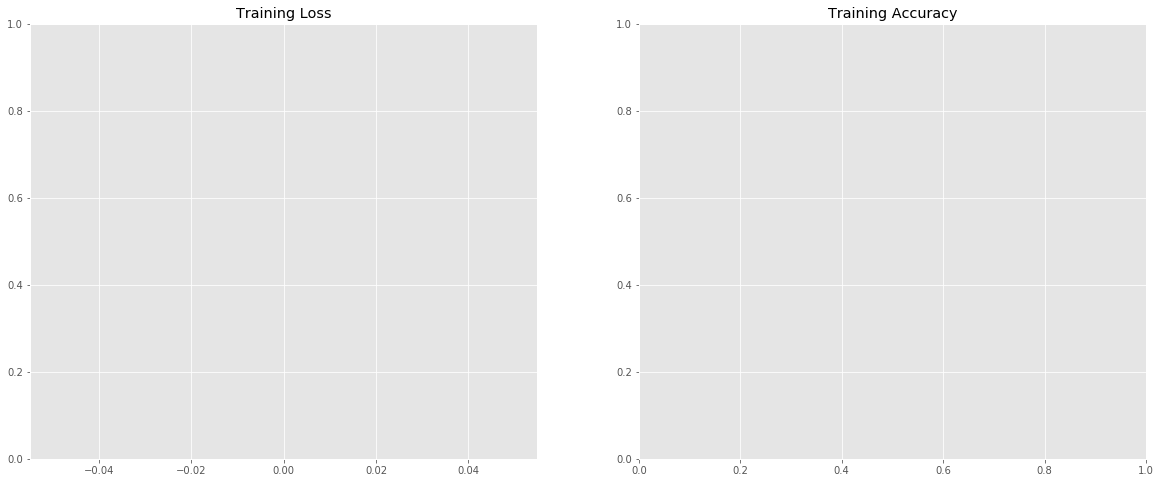

In [48]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### Extract and display model frame, prediction and mask batch

In [ ]:
# training_gen = TrainAugmentGenerator()
testing_gen = TestAugmentGenerator()

In [ ]:

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)


In [ ]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    ax3.grid(b=None)
    
    plt.savefig("SegNet_result_"+str(i))
    plt.show()